# RQ2 - EEG

## Import libraries

In [123]:
import mne
import numpy as np
import scipy.signal as signal
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simps
from tqdm.notebook import tqdm
import os

## Create folder to save results

In [124]:
# create folder RQ2 if not exist
if not os.path.exists('./data/RQ2'):
    os.makedirs('./data/RQ2')

## Load data with the participant Algorithm EEG mapping

In [125]:
df_skill = pd.read_csv(f"./data/filteredData/filtered_data.csv")
df_filtered = df_skill[["Participant", "Algorithm", "SkillScore", "EEG", "CrossEEG"]]
df_skill = df_skill[["Participant", "SkillScore"]]
df_skill = df_skill.drop_duplicates()
df_filtered

,Participant,Algorithm,SkillScore,EEG,CrossEEG
0,1,IsPrime,0.332799,./data/filteredData/Participant01/IsPrimecode_...,./data/filteredData/Participant01/IsPrimecross...
1,1,SiebDesEratosthenes,0.332799,./data/filteredData/Participant01/SiebDesErato...,./data/filteredData/Participant01/SiebDesErato...
2,1,IsAnagram,0.332799,./data/filteredData/Participant01/IsAnagramcod...,./data/filteredData/Participant01/IsAnagramcro...
3,1,RemoveDoubleChar,0.332799,./data/filteredData/Participant01/RemoveDouble...,./data/filteredData/Participant01/RemoveDouble...
4,1,BinToDecimal,0.332799,./data/filteredData/Participant01/BinToDecimal...,./data/filteredData/Participant01/BinToDecimal...
...,...,...,...,...,...
1067,71,DumpSorting,0.437218,./data/filteredData/Participant71/DumpSortingc...,./data/filteredData/Participant71/DumpSortingc...
1068,71,BinomialCoefficient,0.437218,./data/filteredData/Participant71/BinomialCoef...,./data/filteredData/Participant71/BinomialCoef...
1069,71,IsAnagram,0.437218,./data/filteredData/Participant71/IsAnagramcod...,./data/filteredData/Participant71/IsAnagramcro...
1070,71,ArrayAverage,0.437218,./data/filteredData/Participant71/ArrayAverage...,./data/filteredData/Participant71/ArrayAverage...


## Helper methods for performing PSD and bandpower calculations

In [180]:
def get_spectrum(data, sampling_rate, method='welch', decibel=False, resolution='auto'):
    """
    Calculate amplitude or power spectrum

    data: Should be of shape (n_channels, n_samples)
    sampling_rate: Sampling rate... (float)
    method:
        * welch for power spectrum using Welch's method (recommended)
        * ft for simple Fourier transform (amplitude spectrum)
        * ps for power spectrum using a simple fourier transform
    decibel: Convert spectrum to decibel (bool)
    """

    axis = -1

    n_channels, n_samples = data.shape

    if resolution == 'auto':
        n_frequencies = n_samples
    elif isinstance(resolution, (int, float)):
        n_frequencies = np.round(sampling_rate / resolution).astype('int')
    else:
        raise ValueError('\'{}\''.format(resolution))

    # Spectrum
    if method in ['ft', 'ps']:
        # Using FFT
        # Get (complex) spectrum
        spec = np.fft.fft(data, n=n_frequencies, axis=axis)
        freq = np.fft.fftfreq(n_frequencies) * sampling_rate

        # Convert to real positive-sided spectrum
        spec = np.abs(spec)
        nyquist = 0.5 * sampling_rate
        is_positive = np.logical_or(np.logical_and(freq >= 0, freq <= nyquist), freq == -nyquist)
        n_pos = np.sum(is_positive)
        is_positive = np.repeat(is_positive[np.newaxis], n_channels, axis=0)
        spec = np.reshape(spec[is_positive], (n_channels, n_pos))
        freq = np.abs(freq[is_positive])
        is_double = np.logical_and(freq > 0, freq < nyquist)
        is_double = np.repeat(is_double[np.newaxis], n_channels, axis=0)
        spec[is_double] = 2 * spec[is_double]

        if method in ['ps']:
            # Get power spectral density
            spec = (1 / (sampling_rate * n_frequencies)) * spec ** 2

            # Convert to decibel if required
            if decibel:
                spec = _to_decibel(spec)
    elif method in ['welch', 'welch_db']:
        # Using Welch method
        freq, spec = signal.welch(data, sampling_rate, nperseg=n_frequencies, detrend='constant', axis=axis)

        # Convert to decibel if required
        if decibel:
            spec = _to_decibel(spec)
    else:
        raise RuntimeError('Unknown method \'{}\''.format(method))

    return spec, freq

def bandpower(spec, freq, freqband, relative=False):
    """
    Get band power within specified frequency band
    Alternatively: https://raphaelvallat.com/bandpower.html
    """

    spec = np.asarray(spec)
    freq = np.asarray(freq)
    freqband = np.asarray(freqband)

    if spec.ndim != 1:
        raise ValueError('Input \'spec\' bad: {}'.format(spec.shape))

    if freqband.ndim != 1 and freqband.shape[-1] != 2:
        raise ValueError('Input \'freqband\' bad: {}'.format(freqband.shape))

    # Frequency resolution
    step_freq = freq[1] - freq[0]

    # Find closest indices of band in frequency vector
    is_in_freqband = np.logical_and(freq >= np.min(freqband), freq <= np.max(freqband))

    # Integral approximation of the spectrum using Simpson's rule
    bp = simps(spec[is_in_freqband], dx=step_freq)

    if relative:
        bp = bp / simps(spec, dx=step_freq)

    return bp



def _to_decibel(spec):
    return 10 * np.log10(spec)

def get_mental_work_load(eeg_path, sampling_rate=500):
    # read in eeg file
    eeg_data = mne.io.read_raw_fif(eeg_path, preload=True, verbose='ERROR')

    # get raw channel data and do mean average referencing
    eeg_data_raw = eeg_data.get_data()
    eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

    # extract channel names of eeg_data
    channel_names = list(eeg_data.to_data_frame().columns[1:])

    # create mock events for cutting eeg data (number, len, id)
    # events are set every 50 entry to move the window 0.1 seconds every time
    events = np.array([(i, 0, 1) for i in range(0, eeg_data_ref.shape[-1], 50)])

    # create temporal eeg raw for cutting data into epochs
    tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

    # create epochs which have a 3 second window and operate on event id 1
    epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True, verbose='ERROR')

    # calculate Mental Workload for each window
    mwl_array = []

    for epoch_data_raw in epochs:

        # perform power spectrum analysis on eeg data
        spectrum, frequency = get_spectrum(epoch_data_raw, sampling_rate, method='welch', decibel=False, resolution='auto')

        # calculate Mental Workload by dividing the power spectrum of the relative theta band power divided by relative alpha band power
        # on channel Fz for theta and Pc for alpha
        theata_power = bandpower(spectrum[channel_names.index("Fz"), :], frequency, [4.0, 8.0], relative=True)
        alpha_power = bandpower(spectrum[channel_names.index("Pz"), :], frequency, [8.0, 13.0], relative=True)
        MWL = theata_power / alpha_power

        # append Mental Workload to array
        mwl_array.append(MWL)
    return mwl_array

def get_brainwaves(eeg_path, sampling_rate=500):
    # read in eeg file
    eeg_data = mne.io.read_raw_fif(eeg_path, preload=True, verbose='ERROR')

    # get raw channel data and do mean average referencing
    eeg_data_raw = eeg_data.get_data()
    eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

    # extract channel names of eeg_data
    channel_names = list(eeg_data.to_data_frame().columns[1:])

    # create mock events for cutting eeg data (number, len, id)
    # events are set every 50 entry to move the window 0.1 seconds every time
    events = np.array([(i, 0, 1) for i in range(0, eeg_data_ref.shape[-1], 50)])

    # create temporal eeg raw for cutting data into epochs
    tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

    # create epochs which have a 3 second window and operate on event id 1
    epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True, verbose='ERROR')

    alpha = np.array([])
    beta = np.array([])
    gamma = np.array([])
    theta = np.array([])

    for epoch_data_raw in epochs:
        # perform power spectrum analysis on eeg data
        spectrum, frequency = get_spectrum(epoch_data_raw, sampling_rate, method='welch', decibel=False, resolution='auto')

        alpha_current = np.array([])
        beta_current = np.array([])
        gamma_current = np.array([])
        theta_current = np.array([])

        for channel in channel_names:
            alpha_current = np.append(alpha_current, bandpower(spectrum[channel_names.index(channel), :], frequency, [8.0, 13.0], relative=True))
            beta_current = np.append(beta_current, bandpower(spectrum[channel_names.index(channel), :], frequency, [13.0, 30.0], relative=True))
            gamma_current = np.append(gamma_current, bandpower(spectrum[channel_names.index(channel), :], frequency, [30.0, 50.0], relative=True))
            theta_current = np.append(theta_current, bandpower(spectrum[channel_names.index(channel), :], frequency, [4.0, 8.0], relative=True))

        alpha = np.append(alpha, alpha_current)
        beta = np.append(beta, beta_current)
        gamma = np.append(gamma, gamma_current)
        theta = np.append(theta, theta_current)
    return alpha, beta, gamma, theta

## Calculate Mental Workload for each participant for each algorithm

In [127]:
# sampling rate of the EEG data
sampling_rate = 500

# create Mental Workload column
df_filtered["MentalWorkLoad"] = [np.array([]) for i in range(len(df_filtered))]

# iterate over each row anc calculate Mental Workload for the task
for idx in tqdm(range(len(df_filtered))):
    algorithm = df_filtered.iloc[idx]["Algorithm"]
    participant = df_filtered.iloc[idx]["Participant"]
    skill_score = df_filtered.iloc[idx]["SkillScore"]
    eeg_path = df_filtered.iloc[idx]["EEG"]
    cross_eeg_path = df_filtered.iloc[idx]["CrossEEG"]

    # calculate Mental Workload for each algorithm
    mwl_task = get_mental_work_load(eeg_path)

    # calculate Mental Workload for the cross task as baseline
    mwl_base_line = get_mental_work_load(cross_eeg_path)
    base_line_expected_value = np.mean(mwl_base_line)
    base_line_variance = np.var(mwl_base_line)

    # calculate Mental Workload z score
    mwl_z_score = (mwl_task - base_line_expected_value) / base_line_variance

    # append Mental Workload to the current row
    df_filtered.at[idx, "MentalWorkLoad"] = mwl_z_score
df_filtered

  0%|          | 0/1072 [00:00<?, ?it/s]

,Participant,Algorithm,SkillScore,EEG,CrossEEG,MentalWorkLoad
0,1,IsPrime,0.332799,./data/filteredData/Participant01/IsPrimecode_...,./data/filteredData/Participant01/IsPrimecross...,"[1.0593567208726158, 0.50864900819106, 0.06660..."
1,1,SiebDesEratosthenes,0.332799,./data/filteredData/Participant01/SiebDesErato...,./data/filteredData/Participant01/SiebDesErato...,"[4.480620446164993, 4.590111436607497, 4.73709..."
2,1,IsAnagram,0.332799,./data/filteredData/Participant01/IsAnagramcod...,./data/filteredData/Participant01/IsAnagramcro...,"[17.28311550952526, 19.849898618310522, 22.861..."
3,1,RemoveDoubleChar,0.332799,./data/filteredData/Participant01/RemoveDouble...,./data/filteredData/Participant01/RemoveDouble...,"[4.247978826688961, 2.001105428017366, 0.68529..."
4,1,BinToDecimal,0.332799,./data/filteredData/Participant01/BinToDecimal...,./data/filteredData/Participant01/BinToDecimal...,"[-0.11063818421996593, -0.4558017227498615, -0..."
...,...,...,...,...,...,...
1067,71,DumpSorting,0.437218,./data/filteredData/Participant71/DumpSortingc...,./data/filteredData/Participant71/DumpSortingc...,"[2.472280994207292, 1.9215378229127889, 1.2702..."
1068,71,BinomialCoefficient,0.437218,./data/filteredData/Participant71/BinomialCoef...,./data/filteredData/Participant71/BinomialCoef...,"[-0.6260732644590159, -0.6516543741629276, -0...."
1069,71,IsAnagram,0.437218,./data/filteredData/Participant71/IsAnagramcod...,./data/filteredData/Participant71/IsAnagramcro...,"[-0.08213255301678644, -0.0855103675124782, -0..."
1070,71,ArrayAverage,0.437218,./data/filteredData/Participant71/ArrayAverage...,./data/filteredData/Participant71/ArrayAverage...,"[-1.9243041659649414, -1.8421902465817437, -1...."


In [130]:
tmp = df_filtered[["MentalWorkLoad", "Participant", "Algorithm"]]
participant_mwl_over_500 = []
algorithm_mwl_over_500 = []
for idx, row in tmp.iterrows():
    participant = row["Participant"]
    mwl = row["MentalWorkLoad"]
    mwl_mean = np.mean(mwl)
    mwl_std = np.std(mwl)
    algorithm = row["Algorithm"]

    for value in mwl:
        if value > 100:
            participant_mwl_over_500.append(participant)
            algorithm_mwl_over_500.append(algorithm)
            break


print(list(zip(participant_mwl_over_500, algorithm_mwl_over_500)))

[(1, 'RemoveDoubleChar'), (1, 'PermuteString'), (1, 'SumArray'), (1, 'MedianOnSorted'), (1, 'ArrayAverage'), (1, 'Palindrome'), (1, 'HeightOfTree'), (1, 'Ackerman'), (55, 'HIndex'), (63, 'GreatestCommonDivisor'), (63, 'Vehicle'), (63, 'HIndex'), (67, 'PermuteString'), (67, 'IsAnagram'), (67, 'BogoSort'), (67, 'RabbitTortoise'), (67, 'Rectangle'), (67, 'SignChecker'), (67, 'DropNumber'), (67, 'RemoveDoubleChar')]


In [131]:
# save the filtered dataframe to csv
df_tmp = df_filtered.copy()
df_save = df_tmp.copy()
df_tmp["MentalWorkLoad"] = df_tmp["MentalWorkLoad"].apply(lambda series: str(list(series)))
df_tmp.to_csv("./data/RQ2/MentalWorkLoadRaw.csv", sep=";", index=False)

In [177]:
def string_to_list_string(data):
    data = data.replace(' ', ',')
    data = data.replace('\n', ',')
    data = ','.join([element for element in data.split(",") if len(element) > 0])
    if data[1] == ",":
        data = "[" + data[2:]
    return data

df_filtered = pd.read_csv("./data/RQ2/MentalWorkLoadRaw.csv", sep=";")
df_filtered["MentalWorkLoad"] = df_filtered["MentalWorkLoad"].apply(string_to_list_string)
df_filtered["MentalWorkLoad"] = df_filtered["MentalWorkLoad"].apply(lambda x: np.array(eval(x)))

# Calculate metrics and stats for MWL

In [165]:
# stats per algorithm per participant
filter = df_filtered.filter(["MWLLength", "MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope", "PeakToPeak", "MWL_max_slope"])
df_filtered = df_filtered.drop(filter, axis=1)

df_filtered.insert(loc=0, column="MWLLength", value=df_filtered["MentalWorkLoad"].apply(len))
df_filtered.insert(loc=0, column="MWLMean", value=df_filtered["MentalWorkLoad"].apply(np.mean))
df_filtered.insert(loc=0, column="MWLMedian", value=df_filtered["MentalWorkLoad"].apply(np.median))
df_filtered.insert(loc=0, column="MWLStd", value=df_filtered["MentalWorkLoad"].apply(np.std))
df_filtered.insert(loc=0, column="MWLMin", value=df_filtered["MentalWorkLoad"].apply(np.min))
df_filtered.insert(loc=0, column="MWLMax", value=df_filtered["MentalWorkLoad"].apply(np.max))
df_filtered.insert(loc=0, column="PeakToPeak", value=df_filtered["MentalWorkLoad"].apply(np.ptp))
df_filtered.insert(loc=0, column="MWL_max_slope", value=df_filtered["MentalWorkLoad"].apply(lambda x: np.amax(np.diff(x))))
df_filtered.insert(loc=0, column="MWL_average_slope", value=df_filtered["MentalWorkLoad"].apply(lambda x: np.mean(np.diff(x))))
df_filtered.insert(loc=0, column="MWL_total_slope", value=df_filtered["MentalWorkLoad"].apply(lambda x: np.sum(np.diff(x))))

df_filtered

,MWL_total_slope,MWL_average_slope,MWL_max_slope,PeakToPeak,MWLMax,MWLMin,MWLStd,MWLMedian,MWLMean,MWLLength,Participant,Algorithm,SkillScore,EEG,CrossEEG,MentalWorkLoad
0,-1.043289,-0.011218,1.685733,21.138972,19.835501,-1.303471,6.211189,1.058016,4.131999,94,1,IsPrime,0.332799,./data/filteredData/Participant01/IsPrimecode_...,./data/filteredData/Participant01/IsPrimecross...,"[1.0593567208726158, 0.50864900819106, 0.06660..."
1,-0.720182,-0.000482,11.528993,74.043302,72.345785,-1.697517,9.014838,6.267417,8.404891,1496,1,SiebDesEratosthenes,0.332799,./data/filteredData/Participant01/SiebDesErato...,./data/filteredData/Participant01/SiebDesErato...,"[4.480620446164993, 4.590111436607497, 4.73709..."
2,11.407202,0.010711,10.824079,95.978678,92.655316,-3.323362,14.919828,15.971047,19.352919,1066,1,IsAnagram,0.332799,./data/filteredData/Participant01/IsAnagramcod...,./data/filteredData/Participant01/IsAnagramcro...,"[17.28311550952526, 19.849898618310522, 22.861..."
3,21.981208,0.043614,16.402823,114.510635,113.141790,-1.368845,21.929886,26.229187,30.911825,505,1,RemoveDoubleChar,0.332799,./data/filteredData/Participant01/RemoveDouble...,./data/filteredData/Participant01/RemoveDouble...,"[4.247978826688961, 2.001105428017366, 0.68529..."
4,1.265876,0.002699,1.966775,17.398036,15.518148,-1.879888,4.147686,3.094107,3.881699,470,1,BinToDecimal,0.332799,./data/filteredData/Participant01/BinToDecimal...,./data/filteredData/Participant01/BinToDecimal...,"[-0.11063818421996593, -0.4558017227498615, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,2.176083,0.001973,2.197926,29.656343,26.815911,-2.840433,3.363279,-0.212614,0.560515,1104,71,DumpSorting,0.437218,./data/filteredData/Participant71/DumpSortingc...,./data/filteredData/Participant71/DumpSortingc...,"[2.472280994207292, 1.9215378229127889, 1.2702..."
1068,1.626550,0.003417,1.380485,10.863666,9.566315,-1.297351,1.947460,0.482439,1.107000,477,71,BinomialCoefficient,0.437218,./data/filteredData/Participant71/BinomialCoef...,./data/filteredData/Participant71/BinomialCoef...,"[-0.6260732644590159, -0.6516543741629276, -0...."
1069,-0.022926,-0.000021,0.230234,1.350574,1.137597,-0.212978,0.186155,-0.068162,-0.006802,1080,71,IsAnagram,0.437218,./data/filteredData/Participant71/IsAnagramcod...,./data/filteredData/Participant71/IsAnagramcro...,"[-0.08213255301678644, -0.0855103675124782, -0..."
1070,2.056301,0.038798,0.492633,3.533358,1.609054,-1.924304,1.010382,-0.284794,-0.186619,54,71,ArrayAverage,0.437218,./data/filteredData/Participant71/ArrayAverage...,./data/filteredData/Participant71/ArrayAverage...,"[-1.9243041659649414, -1.8421902465817437, -1...."


In [166]:
df_filtered[["MWL_total_slope", "MWL_average_slope", "MWLMax", "MWLMin", "MWLStd", "MWLMedian", "MWLMean", "MWLLength", "Participant", "Algorithm", "SkillScore"]].to_csv("./data/RQ2/MentalWorkLoadStatsRaw.csv")

In [167]:
# stats per participant
df_mwl_participant = df_filtered.groupby(["Participant"]).agg({
    "MWLMean": "mean",
    "MWLMedian": "mean",
    "MWLStd": "mean",
    "MWLMin": "mean",
    "MWLMax": "mean",
    "PeakToPeak": "mean",
    "MWL_max_slope": "mean",
    "MWL_average_slope": "mean",
    "MWL_total_slope": "mean",})
df_mwl_participant = df_mwl_participant.reset_index()
df_mwl_participant["Participant"] = df_mwl_participant["Participant"].astype(int)
df_mwl_participant = pd.merge(df_mwl_participant, df_skill, on="Participant")

# save to csv
df_mwl_participant.to_csv("./data/RQ2/MentalWorkLoadStats.csv")

df_mwl_participant

,Participant,MWLMean,MWLMedian,MWLStd,MWLMin,MWLMax,PeakToPeak,MWL_max_slope,MWL_average_slope,MWL_total_slope,SkillScore
0,1,21.215590,16.210911,16.465412,0.798148,82.903148,82.105000,11.539528,0.101336,5.425498,0.332799
1,2,0.122412,-0.030020,0.668541,-0.764763,3.109814,3.874578,0.466809,-0.000219,0.028036,0.381621
2,3,0.987448,0.526132,1.952345,-1.406921,10.944761,12.351681,1.757627,0.000499,0.241091,0.315012
3,4,0.111093,0.026834,0.415974,-0.409697,1.850077,2.259774,0.298352,0.000259,0.016804,0.426317
4,5,1.513432,1.155283,1.648633,-0.735919,7.878228,8.614146,0.941284,-0.004088,-1.528174,0.313899
5,6,-0.404799,-0.655265,1.289246,-2.252913,4.794019,7.046931,0.861587,0.001369,0.201663,0.318673
6,7,2.563570,1.913307,2.878350,-1.496270,15.230583,16.726853,2.196202,0.002601,-0.929594,0.408083
7,10,2.294620,1.767023,2.503128,-1.165986,11.030678,12.196664,1.521851,0.013180,0.793321,0.350811
8,11,0.698169,0.344840,1.482629,-1.236112,7.581426,8.817538,1.104942,-0.000319,0.226302,0.165306
9,12,0.431989,0.128927,1.254311,-1.349523,6.211800,7.561323,0.900375,0.000113,0.445352,0.309593


In [168]:
df_corr = df_mwl_participant.corrwith(df_mwl_participant["SkillScore"])
df_tmp = pd.DataFrame(df_corr, columns=["Correlation with SkillScore"])
# save df_tmp to csv
df_tmp.to_csv("./data/RQ2/MentalWorkLoadCorrelation.csv")
df_corr

Participant         -0.035655
MWLMean             -0.088879
MWLMedian           -0.079545
MWLStd              -0.125509
MWLMin               0.185899
MWLMax              -0.147712
PeakToPeak          -0.152865
MWL_max_slope       -0.146418
MWL_average_slope    0.009785
MWL_total_slope     -0.106176
SkillScore           1.000000
dtype: float64

## Plotting of Mental Workload stats

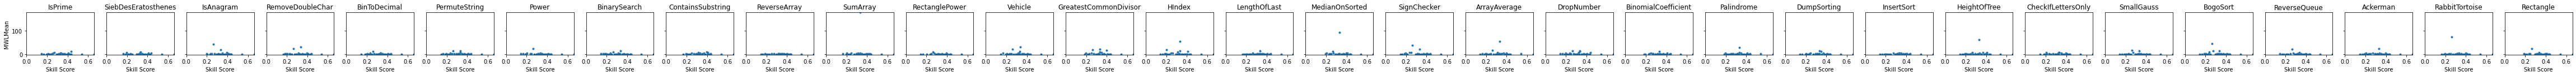

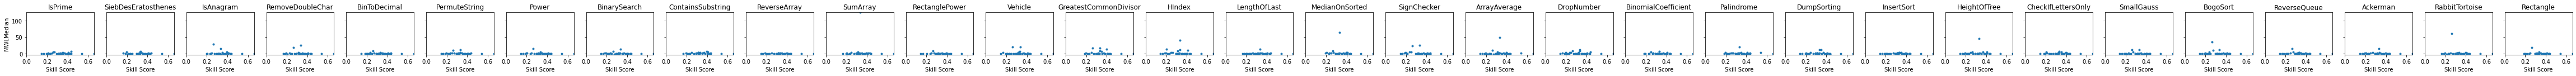

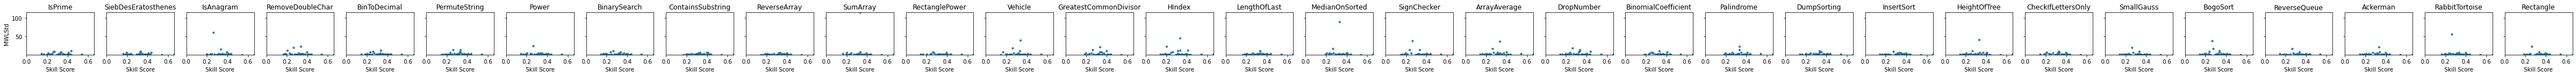

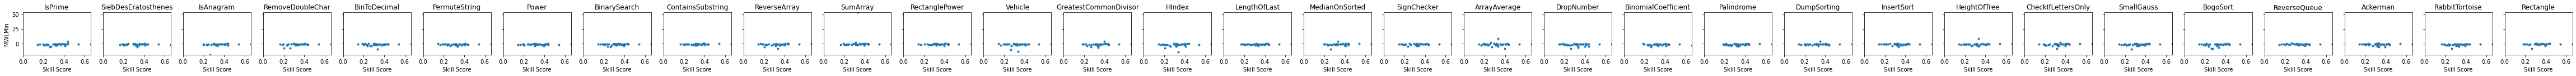

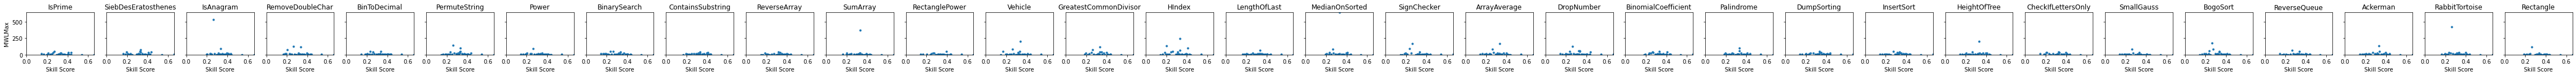

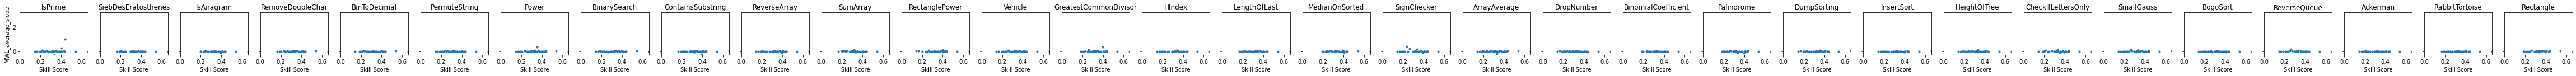

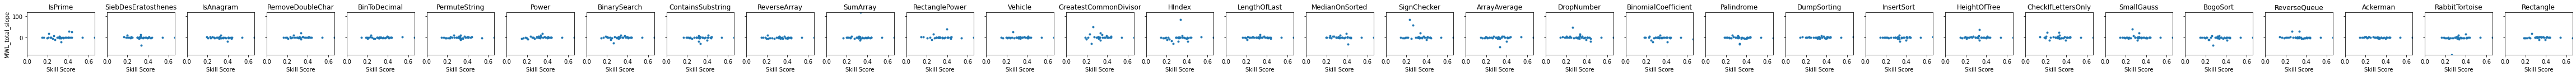

In [147]:
# create folder if not exists
if not os.path.exists("./data/RQ2/plots/MentalWorkLoadStats"):
    os.makedirs("./data/RQ2/plots/MentalWorkLoadStats")

# plot some results
number_of_algorithms = len(df_filtered["Algorithm"].unique())
sample_number = number_of_algorithms

def scatter_plot_metric_skill_score(df, sample_number, column, name=None):
    if name is None:
        name = column
    fig, ax = plt.subplots(1, sample_number, figsize=(sample_number * 2, 2))

    for idx, algorithm in enumerate(df["Algorithm"].unique()[:sample_number]):
        df_filtered_algorithm = df[df["Algorithm"] == algorithm]
        ax[idx].plot(df_filtered_algorithm["SkillScore"], df_filtered_algorithm[column], ".")
        ax[idx].set_title(algorithm)
        ax[idx].set_ylabel(name)
        ax[idx].set_xlabel("Skill Score")
        if idx != 0:
            ax[idx].set(ylabel=None)
            ax[idx].set_yticklabels([])
        ax[idx].set_ylim([df_filtered[column].min(), df_filtered[column].max()])
        ax[idx].set_xlim([0, df_filtered["SkillScore"].max()])
    return fig, ax

for column in ["MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope"]:
    fig, ax = scatter_plot_metric_skill_score(df_filtered, sample_number, column)
    fig.tight_layout()
    plt.savefig("./data/RQ2/plots/MentalWorkLoadStats/" + column + ".pdf")
    plt.show()


## Smooth data by Median Filter for 3 Seconds

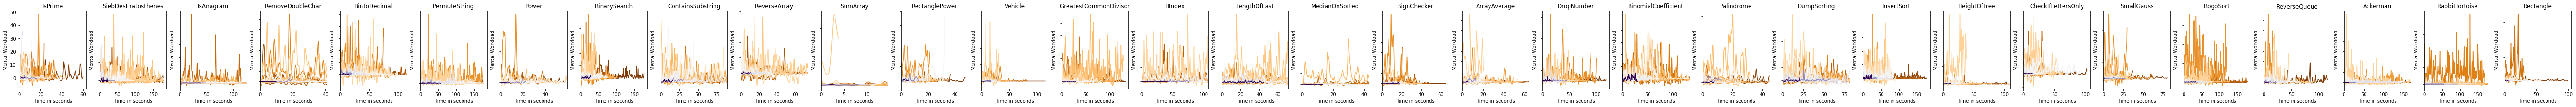

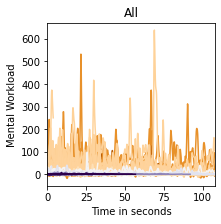

In [178]:
# create folder if not exists
if not os.path.exists("./data/RQ2/plots/MentalWorkLoadPerTime"):
    os.makedirs("./data/RQ2/plots/MentalWorkLoadPerTime")

# plot course of mental workload per algorithm
def course_plot_mwl_color_by_skill_score(df, ax, algorithm=None):
    df_algorithm = df[df["Algorithm"] == algorithm]
    if algorithm is None:
        df_algorithm = df
        algorithm = "All"
    df_algorithm = df_algorithm.sort_values(by=["SkillScore"]).reset_index(drop=True)
    min_skill_score = df_algorithm["SkillScore"].min()
    max_skill_score = df_algorithm["SkillScore"].max()
    cm = plt.get_cmap("PuOr")
    for idx, row in df_algorithm.iterrows():
        time = np.linspace(0, len(row["MentalWorkLoad"]), len(row["MentalWorkLoad"]))
        time = time / 10
        color = cm((row["SkillScore"] - min_skill_score) / (max_skill_score - min_skill_score))
        ax.plot(time, row["MentalWorkLoad"], color=color)
        ax.set_xlabel("Time in seconds")
        ax.set_ylabel("Mental Workload")
        ax.set_title(algorithm)
        ax.set_xlim(0, )


fig, ax = plt.subplots(1, sample_number, figsize=(sample_number * 3, 3))
for idx, algorithm in enumerate(df_filtered["Algorithm"].unique()):
    course_plot_mwl_color_by_skill_score(df_filtered, ax[idx], algorithm)
    if idx != 0:
        ax[idx].set_yticklabels([])
plt.savefig("./data/RQ2/plots/MentalWorkLoadPerTime/MWL_per_algorithm.pdf")
plt.show()


fig, ax = plt.subplots(figsize=(3, 3))
course_plot_mwl_color_by_skill_score(df_filtered, ax)
plt.savefig("./data/RQ2/plots/MentalWorkLoadPerTime/MWL_total.pdf")
plt.show()

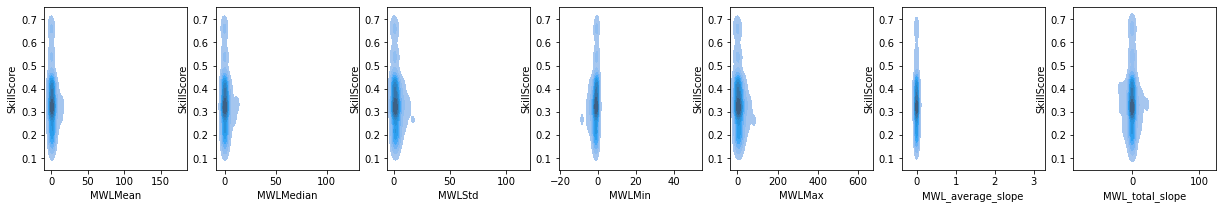

In [161]:
import seaborn as sns

# kdeplot of mental workload vs skill score
columns = ["MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope"]
fig, ax = plt.subplots(1, len(columns), figsize=(len(columns) * 3, 3))
for idx, column in enumerate(columns):
    sns.kdeplot(df_filtered[column], y=df_filtered["SkillScore"], ax=ax[idx], label=column, shade=True)
plt.savefig("./data/RQ2/plots/MentalWorkLoadStats/kde_mwl.pdf")
plt.show()

## Generate Topographical Plots

In [ ]:
if not os.path.exists("./data/RQ2/plots/TopographicalPlots"):
    os.makedirs("./data/RQ2/plots/TopographicalPlots")

# sampling rate of the EEG data
sampling_rate = 500

# read in montage and calculate the electrode positions
montage_path = "./data/EEG/AC-64.bvef"
montage = mne.channels.read_custom_montage(montage_path, head_size=0.085)

# get algorithm names and participants grouping
algo_names = df_filtered["Algorithm"].unique()
algo_names.sort()
participants = df_filtered["Participant"].unique()

# create Mental Workload column
df_filtered["MentalWorkLoad"] = [np.array([]) for i in range(len(df_filtered))]

# iterate over each row anc calculate Mental Workload for the task
for participant in tqdm(participants, total=len(participants)):
    df_participant = df_filtered[df_filtered["Participant"] == participant]
    skill_score = df_participant.iloc[0]["SkillScore"]

    # create figure for total topographical plot of all algorithms
    fig = plt.figure(constrained_layout=True, figsize=(6, len(algo_names) * 3))
    fig.suptitle(f"Participant {participant} - Skill Score: {skill_score}")

    # create algo_names subfigures for topographical plots
    subfigures = fig.subfigures(nrows=len(algo_names), ncols=1)

    # get the eeg data for the participant and each algorithm
    for idx, algorithm in tqdm(enumerate(algo_names), total=len(algo_names)):
        df_algorithm = df_participant[df_participant["Algorithm"] == algorithm]

        # set the title of the subfigure
        subfigures[idx].suptitle(f"Topographical Plot for {algorithm}")

        # get the axis object
        ax = subfigures[idx].subplots(nrows=1, ncols=2)

        if len(df_algorithm) == 0:
            continue

        eeg_path = df_algorithm.iloc[0]["EEG"]

        # read in eeg file
        eeg_data = mne.io.read_raw_fif(eeg_path, preload=True, verbose='ERROR')

        # set montage
        eeg_data.set_montage(montage)

        # get raw channel data and do mean average referencing
        eeg_data_raw = eeg_data.get_data()
        eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

        # create mock events for cutting eeg data (number, len, id)
        # events are set every 50 entry to move the window 0.1 seconds every time
        events = np.array([(i, 0, 1) for i in range(0, eeg_data_ref.shape[-1], 50)])

        # create temporal eeg raw for cutting data into epochs
        tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

        # create epochs which have a 3 second window and operate on event id 1
        epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True, verbose='ERROR')

        # get the corresponding algorithm index
        epochs.plot_psd_topomap(bands=[(4.0, 8.0, "theta"), (8.0, 12.0, "alpha")], axes=ax, show=False, cmap='jet', verbose='ERROR')
    plt.savefig(f"./data/RQ2/plots/TopographicalPlots/Topo_Skill_{skill_score:.4f}_Participant_{participant}.pdf")
    plt.close()

## Lee Replication

In [ ]:
# glättung des eeg signals
# moving mean filter von einer sekunde
# topoplots for each participant
# topoplots per 1/3


# pro elektro alpha band power berechnen
# pro elektro beta band power berechnen
# pro elektro gamma band power berechnen
# pro elektro theta band power berechnen

# mean gebildet prop proband und corr für alle tasks

# lobes
# einteilung in f c p
# mean gebildet pro proband und corr für alle tasks


In [193]:
# read in montage and calculate the electrode positions
df_skill = pd.read_csv(f"./data/filteredData/filtered_data.csv")
df_eeg_data = df_skill[["Participant", "Algorithm", "SkillScore", "EEG", "CrossEEG"]]

# sampling rate of the EEG data
sampling_rate = 500

# create Mental Workload column
df_brain_waves = pd.DataFrame(columns=["Participant", "SkillScore", "Algorithm", "Alpha", "Beta", "Gamma", "Theta"])

# iterate over each row anc calculate Mental Workload for the task
for idx in tqdm(range(len(df_eeg_data))):
    participant = df_eeg_data.iloc[idx]["Participant"]
    skill_score = df_eeg_data.iloc[idx]["SkillScore"]
    algorithm = df_eeg_data.iloc[idx]["Algorithm"]
    eeg_path = df_eeg_data.iloc[idx]["EEG"]
    cross_eeg_path = df_eeg_data.iloc[idx]["CrossEEG"]

    alpha, beta, gamma, theta =  get_brainwaves(eeg_path)
    length = int(len(alpha) / 64)
    alpha = alpha.reshape(64, length)
    beta = beta.reshape(64, length)
    gamma = gamma.reshape(64, length)
    theta = theta.reshape(64, length)
    df_brain_waves.loc[len(df_brain_waves)] = [participant, skill_score, algorithm, alpha, beta, gamma, theta]

  0%|          | 0/1072 [00:00<?, ?it/s]

In [209]:
# read in one example file
example_cross_file = df_eeg_data.iloc[0]["CrossEEG"]
# read in the cross file
cross_eeg_data = mne.io.read_raw_fif(example_cross_file, verbose='ERROR')
# get the channel names
channel_names = cross_eeg_data.ch_names

df_brain_waves_values = pd.DataFrame(columns=["Participant", "SkillScore", "Channel", "Alpha", "Beta", "Gamma", "Theta"])

for participant in tqdm(df_brain_waves["Participant"].unique(), total=len(df_brain_waves["Participant"].unique())):
    df_participant = df_brain_waves[df_brain_waves["Participant"] == participant]
    skill_score = df_participant["SkillScore"].unique()[0]

    merged_alpha = np.zeros(shape=(64,0))
    merged_beta = np.zeros(shape=(64,0))
    merged_gamma = np.zeros(shape=(64,0))
    merged_theta = np.zeros(shape=(64,0))

    for idx, row in df_participant.iterrows():
        alpha = row["Alpha"]
        beta = row["Beta"]
        gamma = row["Gamma"]
        theta = row["Theta"]

        merged_alpha = np.concatenate((merged_alpha, alpha), axis=1)
        merged_beta = np.concatenate((merged_beta, beta), axis=1)
        merged_gamma = np.concatenate((merged_gamma, gamma), axis=1)
        merged_theta = np.concatenate((merged_theta, theta), axis=1)

    for idx, channel in enumerate(channel_names):
        alpha_channeled = merged_alpha[idx, :]
        beta_channeled = merged_beta[idx, :]
        gamma_channeled = merged_gamma[idx, :]
        theta_channeled = merged_theta[idx, :]

        alpha_mean = np.mean(alpha_channeled)
        beta_mean = np.mean(beta_channeled)
        gamma_mean = np.mean(gamma_channeled)
        theta_mean = np.mean(theta_channeled)

        df_brain_waves_values.loc[len(df_brain_waves_values)] = [participant, skill_score, channel, alpha_mean, beta_mean, gamma_mean, theta_mean]

  0%|          | 0/37 [00:00<?, ?it/s]

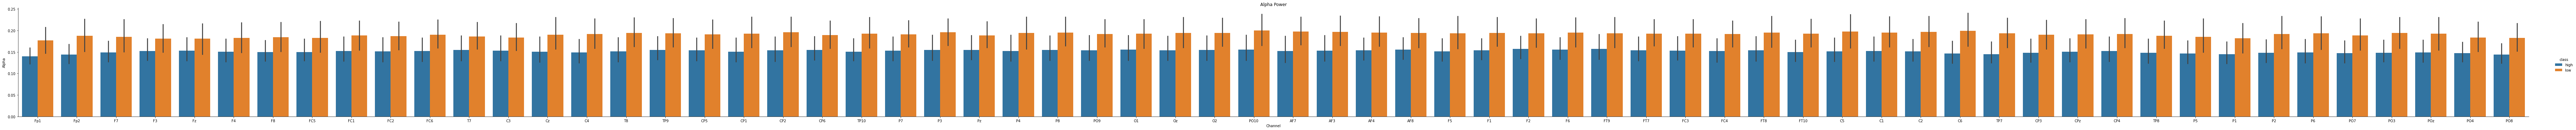

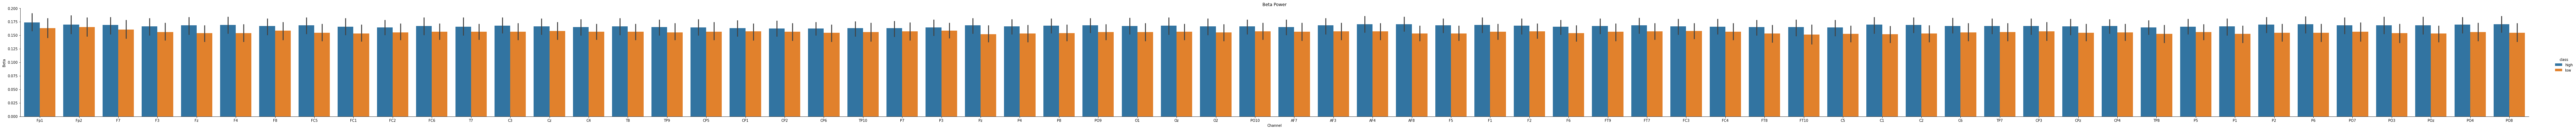

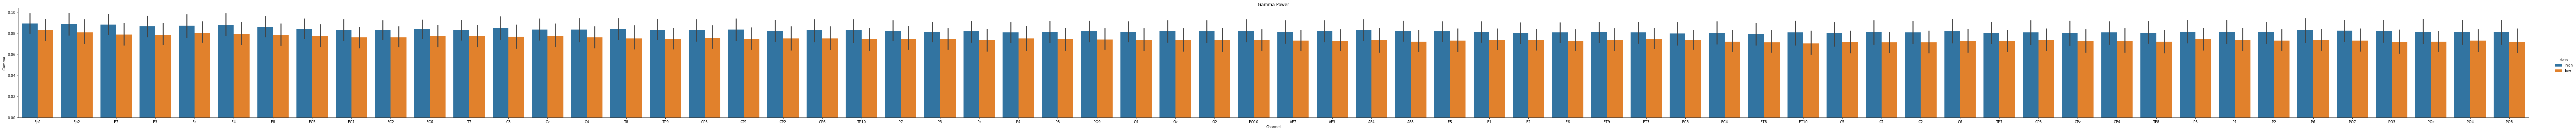

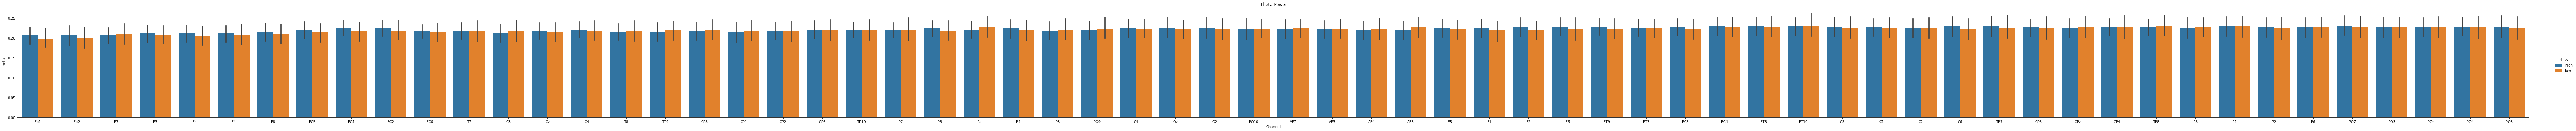

In [225]:
import seaborn as sns

quantile = df_brain_waves_values["SkillScore"].quantile([0.33, 0.66])
lower = quantile[0.33]
upper = quantile[0.66]

# split the dataframe based on the skill score, lowest 33% and highest 33%
df_tmp = df_brain_waves_values.copy()
df_tmp["class"] = "None"
df_tmp.loc[df_tmp["SkillScore"] < lower, "class"] = "low"
df_tmp.loc[df_tmp["SkillScore"] > upper, "class"] = "high"
df_tmp = df_tmp[df_tmp["class"] != "None"]

for cat in ["Alpha", "Beta", "Gamma", "Theta"]:
    sns.catplot(x="Channel", y=cat, hue="class", data=df_tmp, kind="bar", height=5, aspect=20)
    plt.title(f"{cat} Power")
    plt.savefig(f"./data/RQ2/plots/{cat}_power_per_electrode.pdf")
    plt.show()

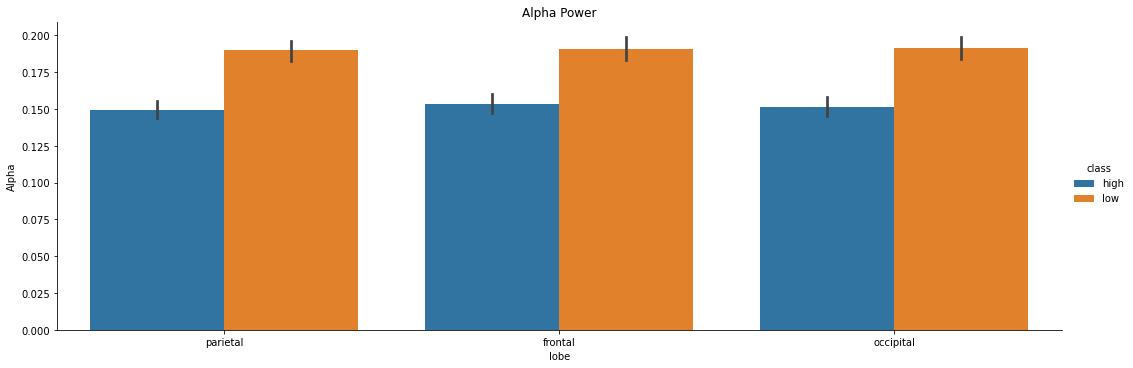

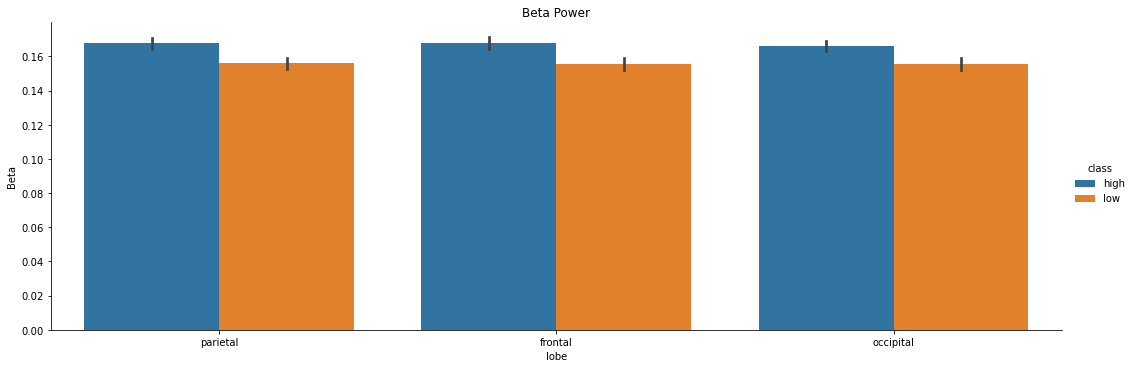

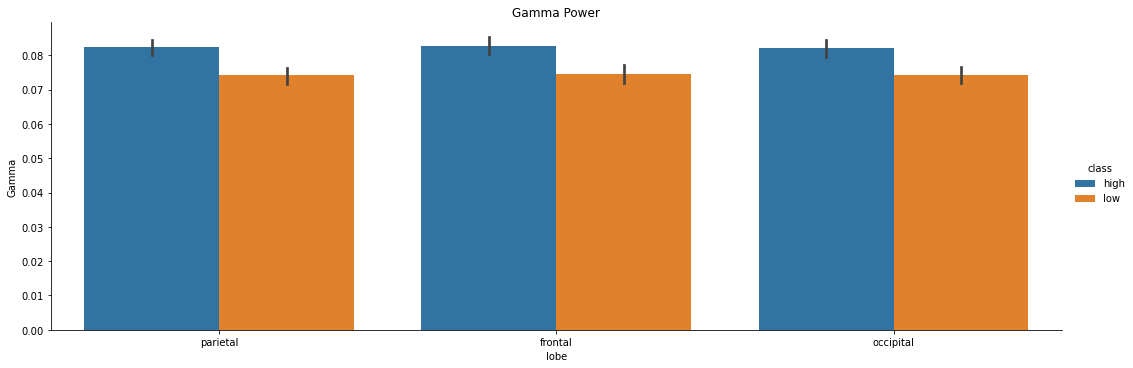

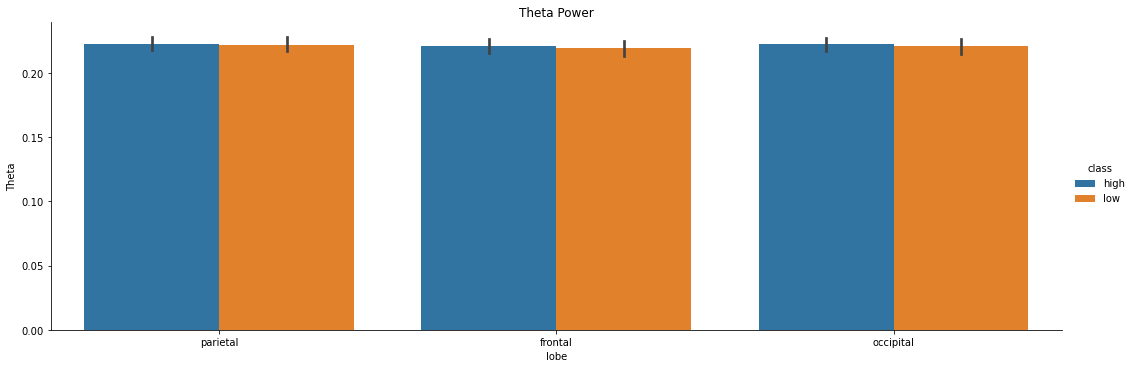

In [222]:
# classifiy lobe
df_tmp["lobe"] = "None"
df_tmp.loc[(df_tmp["Channel"].str.contains("F")) | (df_tmp["Channel"].str.contains("f")), "lobe"] = "frontal"
df_tmp.loc[(df_tmp["Channel"].str.contains("P")) | (df_tmp["Channel"].str.contains("p")), "lobe"] = "parietal"
df_tmp.loc[(df_tmp["Channel"].str.contains("C")) | (df_tmp["Channel"].str.contains("c")), "lobe"] = "occipital"
df_tmp = df_tmp[df_tmp["lobe"] != "None"]

for cat in ["Alpha", "Beta", "Gamma", "Theta"]:
    sns.catplot(x="lobe", y=cat, hue="class", data=df_tmp, kind="bar", height=5, aspect=3)
    plt.title(cat + " Power")
    plt.savefig("./data/RQ2/plots/" + cat + "_power_per_lobe.pdf")
    plt.show()